In [95]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import RFE
import matplotlib.pyplot as pyplot
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import VarianceThreshold
from pandas.api.types import is_numeric_dtype, is_categorical_dtype, is_string_dtype
from datapreparation import *
from sklearn.utils import resample
from sklearn.metrics import classification_report, SCORERS, roc_curve, auc
from model_training import *

ModuleNotFoundError: No module named 'model_training'

In [34]:
flights = pd.read_csv('/Users/user/Documents/Github/flightstatus/data/dev/flights_processed.csv')

In [49]:
datatrain = flights[flights.MONTH<=6]
dataval = flights[(flights.MONTH>=7)&(flights.MONTH<=9)]
datatest = flights[flights.MONTH<=10]

In [65]:
def create_Xy(data):
    return data.drop(['TARGET'], axis=1), data['TARGET']

In [67]:
X_train, y_train = create_Xy(datatrain)
X_val, y_val = create_Xy(dataval)
X_test, y_test = create_Xy(datatest)

# One starting model

In [59]:
m_xgb = XGBClassifier(max_depth=5,
                      min_child_weight=5,
                      subsample=0.8,
                      colsample_bytree=0.8,
                      learning_rate = 0.1,
                      reg_alpha = 0, reg_lambda = 0, gamma=0,
                      objective= 'binary:logistic',
                      random_state=123,
                      n_jobs=-1, n_estimators = 999)

m_xgb.fit(datatrain.drop(['TARGET'], axis=1), datatrain['TARGET'], 
          eval_set=[(datatrain.drop(['TARGET'], axis=1), datatrain['TARGET']),
                   (dataval.drop(['TARGET'], axis=1), dataval['TARGET'])], 
          eval_metric=['logloss'], early_stopping_rounds=5, verbose=True)

[0]	validation_0-logloss:0.677648	validation_1-logloss:0.678281
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.668023	validation_1-logloss:0.664569
[2]	validation_0-logloss:0.657405	validation_1-logloss:0.653934
[3]	validation_0-logloss:0.649599	validation_1-logloss:0.645305
[4]	validation_0-logloss:0.642113	validation_1-logloss:0.637939
[5]	validation_0-logloss:0.637189	validation_1-logloss:0.631063
[6]	validation_0-logloss:0.632017	validation_1-logloss:0.625779
[7]	validation_0-logloss:0.627993	validation_1-logloss:0.62101
[8]	validation_0-logloss:0.62461	validation_1-logloss:0.617323
[9]	validation_0-logloss:0.62163	validation_1-logloss:0.61377
[10]	validation_0-logloss:0.619126	validation_1-logloss:0.611997
[11]	validation_0-logloss:0.616873	validation_1-logloss:0.609529
[12]	validation_0-logloss:0.615217	validation_1-logloss:0.607385
[13]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=999, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

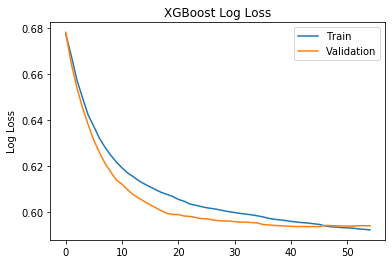

In [63]:
# retrieve performance metrics
results = m_xgb.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

In [61]:
print(classification_report(dataval['TARGET'], m_xgb.predict(dataval.drop(['TARGET'],axis=1))))

              precision    recall  f1-score   support

           0       0.72      0.86      0.79   1004446
           1       0.54      0.33      0.41    491754

    accuracy                           0.69   1496200
   macro avg       0.63      0.59      0.60   1496200
weighted avg       0.66      0.69      0.66   1496200



# Hyperparameter Tuning: Random Search

In [87]:
parameter_grid = {
    'max_depth' : list(range(3,20)), 
    'min_child_weight': list(range(2,20)),
    'subsample' : [i/10.0 for i in range(5, 11)], 
    'colsample_bytree' : [i/10.0 for i in range(5, 11)],
    'learning_rate' : np.linspace(0.001,2,100)
}

number_models = 50
random_XGB_class = RandomizedSearchCV(estimator = XGBClassifier(objective= 'binary:logistic', n_estimators = 999), 
                                      param_distributions = parameter_grid, n_iter = number_models, 
                                      scoring='f1', cv = 5, refit=True, return_train_score = True,
                                      n_jobs=-1)
random_XGB_class.fit(X_train, y_train, eval_set= [(X_val, y_val)], eval_metric='logloss', early_stopping_rounds=5)

[0]	validation_0-logloss:0.605341
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.600192
[2]	validation_0-logloss:0.603095
[3]	validation_0-logloss:0.613481
[4]	validation_0-logloss:0.614948
[5]	validation_0-logloss:0.614856
[6]	validation_0-logloss:0.624737
Stopping. Best iteration:
[1]	validation_0-logloss:0.600192



RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=999,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0...
       1.85865657e+00, 1.87884848e+00, 1.89904040e+00, 1.91923232e+00,
       1.93942424e+00, 1.95961616e+00, 1.97980808e+00, 2.00000000e+00]),
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,

In [85]:
def search_result(searchcv):
    result = pd.DataFrame.from_dict(searchcv.cv_results_['params'])
    result['mean_score'] = searchcv.cv_results_['mean_test_score']
    result['std_score'] = searchcv.cv_results_['std_test_score']
    return result.sort_values('mean_score', ascending=False)

In [89]:
# t = search_result(random_XGB_class)
# t.to_csv('randomsearch.csv')

In [92]:
rs_result = pd.read_csv('randomsearch.csv')

In [93]:
rs_result.head()

,model,colsample_bytree,learning_rate,max_depth,min_child_weight,subsample,mean_score,std_score
0,11,1.0,1.212515,3,19,0.8,0.399653,0.058687
1,42,0.7,1.575970,8,2,0.8,0.371139,0.043006
2,41,0.7,0.970212,19,6,0.6,0.367055,0.053566
3,8,0.6,1.050980,19,4,0.5,0.363797,0.048048
4,43,0.9,1.798081,5,7,0.9,0.363560,0.024876
